# Spherical Harmonics

In this notebook we try to reproduce the eigenfunctions of the Laplacian on the 2D sphere embedded in $\mathbb{R}^3$. The eigenfunctions are the spherical harmonics $Y_l^m(\theta, \phi)$.

In [1]:
import numpy as np

from pydiffmap import diffusion_map as dm
from scipy.sparse import csr_matrix

np.random.seed(100)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## generate data on a Sphere

we sample longitude and latitude uniformly and then transform to $\mathbb{R}^3$ using geographical coordinates (latidude is measured from the equator).

In [2]:
m = 10000
Phi = 2*np.pi*np.random.rand(m) - np.pi
Theta = np.pi*np.random.rand(m) - 0.5*np.pi
X = np.cos(Theta)*np.cos(Phi)
Y = np.cos(Theta)*np.sin(Phi)
Z = np.sin(Theta)
data = np.array([X, Y, Z]).transpose()



## run diffusion maps

Now we initialize the diffusion map object and fit it to the dataset. We set n_evecs = 4, and since we want to unbias with respect to the non-uniform sampling density we set alpha = 1.0. The epsilon parameter controls the scale and is set here by hand. The k parameter controls the neighbour lists, a smaller k will increase performance but decrease accuracy.

In [3]:
eps = 0.01
mydmap = dm.DiffusionMap.from_sklearn(n_evecs=4, epsilon=eps, alpha=1.0, k=400)
mydmap.fit_transform(data)
test_evals = -4./eps*(mydmap.evals - 1)
print(test_evals)

0.01 eps fitted
[1116.4945497  1143.35090854 1147.22344311 2378.50043128]


The true eigenfunctions here are spherical harmonics $Y_l^m(\theta, \phi)$ and the true eigenvalues are $\lambda_l = l(l+1)$. The eigenfunction corresponding to $l=0$ is the constant function, which we ommit. Since $l=1$ has multiplicity three, this gives the benchmark eigenvalues [2, 2, 2, 6].

In [4]:
real_evals = np.array([2, 2, 2, 6])
test_evals = -4./eps*(mydmap.evals - 1)
eval_error = np.abs(test_evals-real_evals)/real_evals
print(test_evals)
print(eval_error)

[1116.4945497  1143.35090854 1147.22344311 2378.50043128]
[557.24727485 570.67545427 572.61172156 395.41673855]


## visualisation

With pydiffmap's visualization toolbox, we can get a quick look at the embedding produced by the first two diffusion coordinates and the data colored by the first eigenfunction.

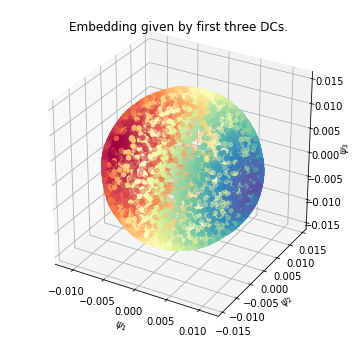

In [5]:
from pydiffmap.visualization import embedding_plot, data_plot

embedding_plot(mydmap, dim=3, scatter_kwargs = {'c': mydmap.dmap[:,0], 'cmap': 'Spectral'})

plt.show()

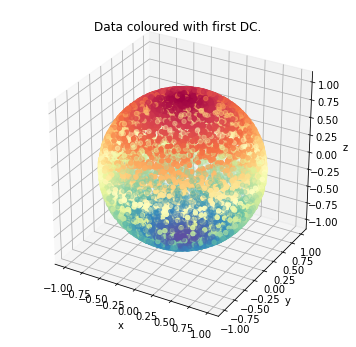

In [6]:
data_plot(mydmap, dim=3, scatter_kwargs = {'cmap': 'Spectral'})
plt.show()

## Rotating the dataset

There is rotational symmetry in this dataset. To remove it, we define the 'north pole' to be the point where the first diffusion coordinate attains its maximum value.

In [7]:
northpole = np.argmax(mydmap.dmap[:,0])
north = data[northpole,:]
phi_n = Phi[northpole]
theta_n = Theta[northpole]
R = np.array([[np.sin(theta_n)*np.cos(phi_n), np.sin(theta_n)*np.sin(phi_n), -np.cos(theta_n)],
              [-np.sin(phi_n), np.cos(phi_n), 0],
             [np.cos(theta_n)*np.cos(phi_n), np.cos(theta_n)*np.sin(phi_n), np.sin(theta_n)]])

In [8]:
data_rotated = np.dot(R,data.transpose())
data_rotated.shape

(3, 10000)

Now that the dataset is rotated, we can check how well the first diffusion coordinate approximates the first spherical harmonic $Y_1^1(\theta, \phi) = \sin(\theta) = Z$.

Correlation between \phi and \psi_1
[[1.         0.99915563]
 [0.99915563 1.        ]]


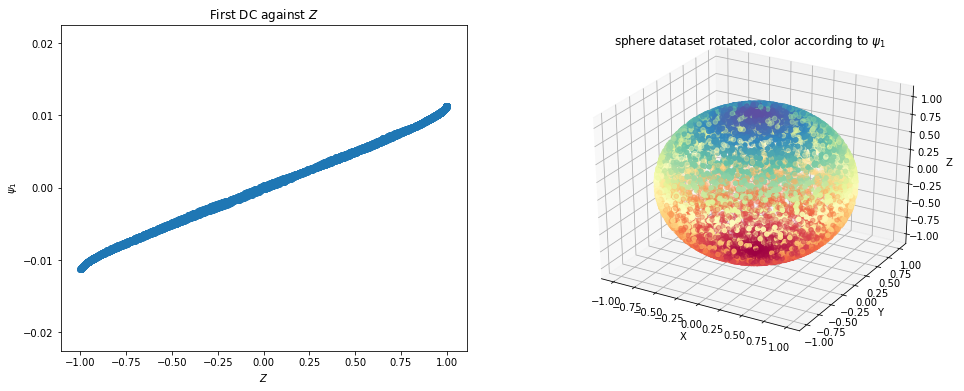

In [9]:
print('Correlation between \phi and \psi_1')
print(np.corrcoef(mydmap.dmap[:,0], data_rotated[2,:]))

plt.figure(figsize=(16,6))
ax = plt.subplot(121)
ax.scatter(data_rotated[2,:], mydmap.dmap[:,0])
ax.set_title('First DC against $Z$')
ax.set_xlabel(r'$Z$')
ax.set_ylabel(r'$\psi_1$')
ax.axis('tight')

ax2 = plt.subplot(122,projection='3d')
ax2.scatter(data_rotated[0,:],data_rotated[1,:],data_rotated[2,:], c=mydmap.dmap[:,0], cmap=plt.cm.Spectral)
#ax2.view_init(75, 10)
ax2.set_title('sphere dataset rotated, color according to $\psi_1$')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.show()